In [3]:
import os
from alpha_vantage.timeseries import TimeSeries # can only get last 100 days
import matplotlib.pyplot as plt
import matplotlib
import requests 
import pandas as pd
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

In [4]:
API_KEY = os.environ['API_KEY']

## Use a python wrapper for alpha_vantage

In [5]:
stock_name = 'TSCO'
time_interval = '60min'
ts = TimeSeries(key=API_KEY, output_format='pandas')
data, meta_data = ts.get_intraday(symbol=stock_name,interval=time_interval, outputsize='full')

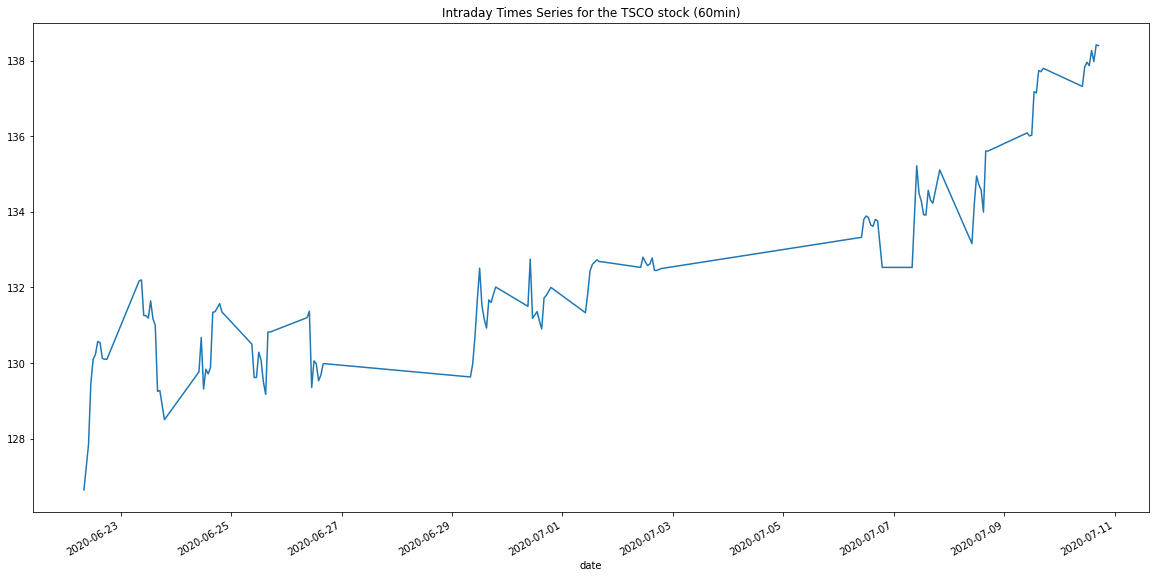

In [6]:
data['4. close'].plot()
plt.title(f'Intraday Times Series for the {stock_name} stock ({time_interval})')
plt.show()

## Use a RESTful api call of alpha_vantage directly

In [7]:
def form_query_string(arg_dic):
    # return a formatted query string for alpha_vantage
    api_call_header='https://www.alphavantage.co/query?'
    api_call_body = '&'.join([f'{key}={val}' for key, val in arg_dic.items()])
    return api_call_header+api_call_body

In [8]:
def query_dataset(query_string):
    # return: stock_meta (dic contains meta data), prices_df (pandas data frame contains price info)
    r = requests.get(query_string, stream=True)
    stock_meta = r.json()['Meta Data']
    
    stock_prices = r.json()['Time Series (Daily)']
    prices_df = pd.DataFrame.from_dict(stock_prices, orient='index')
    prices_df.index = pd.to_datetime(prices_df.index) # change index from str to datatime
    prices_df = prices_df.astype(float) # change prices from str to float
    return stock_meta, prices_df

In [9]:
def plot_column_vs_time(column_name, prices_dfs, stock_metas, ax):
    # a helper function for 
    # plotting on the ax inputed and return a formatted string for title
    for prices_df in prices_dfs:
        prices_df[column_name][:NUM_OF_DAYS].plot(ax=ax) 
    ax.legend([stock_meta["2. Symbol"] for stock_meta in stock_metas])
    stock_symbols = ' & '.join([stock_meta["2. Symbol"] for stock_meta in stock_metas])
    return f'Daily {column_name} Time Series of {stock_symbols} for {NUM_OF_DAYS} days'

### e.g. query stock Tractor Supply Company (TSCO) and  (COST)

only available for US stocks

In [10]:
stock_names = ["TSCO", "COST"]
# one way to query, other ways see api docs
form_arg_dic = lambda stock_name: {'function':'TIME_SERIES_DAILY_ADJUSTED',
           'symbol':stock_name,
           'apikey':API_KEY,
           'outputsize':'full'
          } 

In [11]:
arg_dics = [form_arg_dic(stock_name) for stock_name in stock_names]
arg_dics

[{'function': 'TIME_SERIES_DAILY_ADJUSTED',
  'symbol': 'TSCO',
  'apikey': 'QFUIE96WGG0U9FR2',
  'outputsize': 'full'},
 {'function': 'TIME_SERIES_DAILY_ADJUSTED',
  'symbol': 'COST',
  'apikey': 'QFUIE96WGG0U9FR2',
  'outputsize': 'full'}]

In [12]:
api_calls = [form_query_string(arg_dic) for arg_dic in arg_dics]
api_calls

['https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=TSCO&apikey=QFUIE96WGG0U9FR2&outputsize=full',
 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=COST&apikey=QFUIE96WGG0U9FR2&outputsize=full']

In [13]:
stock_metas, prices_dfs = [], []
for api_call in api_calls:
    stock_meta, prices_df = query_dataset(api_call)
    stock_metas.append(stock_meta)
    prices_dfs.append(prices_df)

In [14]:
stock_metas

[{'1. Information': 'Daily Time Series with Splits and Dividend Events',
  '2. Symbol': 'TSCO',
  '3. Last Refreshed': '2020-07-10',
  '4. Output Size': 'Full size',
  '5. Time Zone': 'US/Eastern'},
 {'1. Information': 'Daily Time Series with Splits and Dividend Events',
  '2. Symbol': 'COST',
  '3. Last Refreshed': '2020-07-10',
  '4. Output Size': 'Full size',
  '5. Time Zone': 'US/Eastern'}]

In [15]:
prices_dfs[0].head()

,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient
2020-07-10,137.70,138.65,136.00,138.42,138.42,651500.0,0.0,1.0
2020-07-09,136.50,138.06,135.16,137.70,137.70,976600.0,0.0,1.0
2020-07-08,134.15,135.70,132.96,135.61,135.61,734600.0,0.0,1.0
2020-07-07,133.18,135.43,132.90,134.23,134.23,823600.0,0.0,1.0
2020-07-06,134.26,134.50,132.92,133.76,133.76,588500.0,0.0,1.0


In [16]:
prices_dfs[1].head()

,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient
2020-07-10,326.00,327.40,323.11,326.23,326.23,2484100.0,0.0,1.0
2020-07-09,320.00,328.98,319.68,325.54,325.54,5313600.0,0.0,1.0
2020-07-08,317.14,318.05,314.01,316.32,316.32,2364500.0,0.0,1.0
2020-07-07,310.02,318.05,309.72,316.23,316.23,3346600.0,0.0,1.0
2020-07-06,307.53,311.56,307.24,311.49,311.49,2332400.0,0.0,1.0


In [17]:
NUM_OF_DAYS = 500 #e.g last 500 days
prices_dfs[0].columns

Index(['1. open', '2. high', '3. low', '4. close', '5. adjusted close',
       '6. volume', '7. dividend amount', '8. split coefficient'],
      dtype='object')

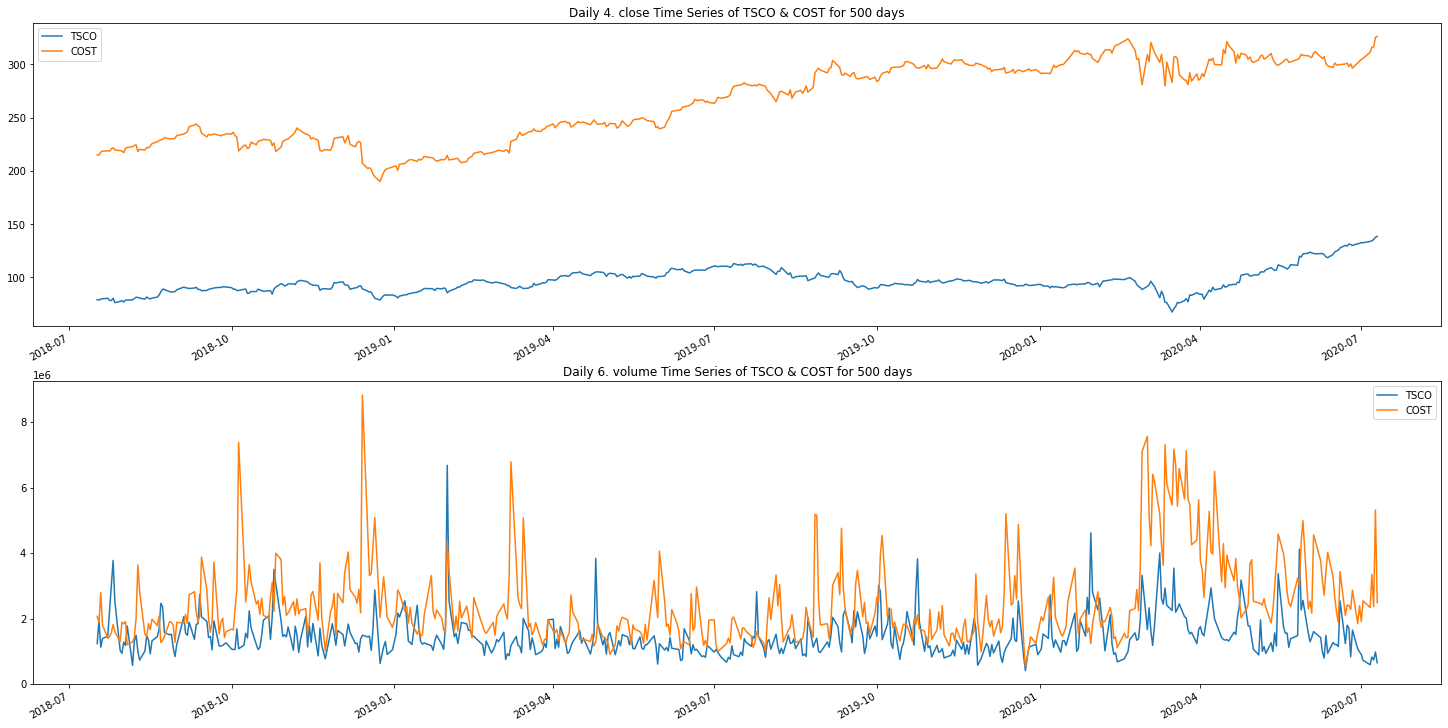

In [23]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)

# plot closing prices for Tesco and Costco
plot_title1 = plot_column_vs_time('4. close',prices_dfs, stock_metas, ax1)
ax1.set_title(label=plot_title1)

# plot trading volumes for Tesco and Costco
plot_title2 = plot_column_vs_time('6. volume',prices_dfs, stock_metas, ax2)
ax2.set_title(label=plot_title2)

fig.tight_layout(pad=0.3)

In [20]:
plot_title1

'Daily 4. close Time Series of TSCO & COST for 500 days'

In [27]:
prices_dfs[0]

,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient
2020-07-10,137.70,138.65,136.00,138.42,138.4200,651500.0,0.0,1.0
2020-07-09,136.50,138.06,135.16,137.70,137.7000,976600.0,0.0,1.0
2020-07-08,134.15,135.70,132.96,135.61,135.6100,734600.0,0.0,1.0
2020-07-07,133.18,135.43,132.90,134.23,134.2300,823600.0,0.0,1.0
2020-07-06,134.26,134.50,132.92,133.76,133.7600,588500.0,0.0,1.0
...,...,...,...,...,...,...,...,...
2000-07-14,14.88,15.00,14.81,14.81,0.8265,3700.0,0.0,1.0
2000-07-13,14.31,14.88,14.31,14.88,0.8304,66700.0,0.0,1.0
2000-07-12,14.34,14.75,14.31,14.50,0.8092,40700.0,0.0,1.0
2000-07-11,14.13,14.13,13.75,14.00,0.7813,49300.0,0.0,1.0
